# Practice2 (test_submission1_3, 2_3.csv)
> Public Score
> - test_submission1_3: 33502.14964
> - test_submission2_3: 34144.87821

In [1]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [94]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [95]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [96]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [97]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [98]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


Id  LotArea Street LotConfig  OverallQual  OverallCond  YearBuilt  \
0    1341    11200   Pave    Inside            5            5       1965   
1    1342     7200   Pave    Corner            5            7       1951   
2    1343    16905   Pave    Inside            5            6       1959   
3    1344     9180   Pave   CulDSac            5            7       1983   
4    1345     7200   Pave    Inside            5            7       1920   
..    ...      ...    ...       ...          ...          ...        ...   
125  1466    11478   Pave    Inside            8            5       2007   
126  1467    16321   Pave   CulDSac            5            6       1957   
127  1468     6324   Pave    Inside            4            6       1927   
128  1469     8500   Pave    Inside            4            4       1920   
129  1470     8544   Pave   CulDSac            5            6       1966   

     YearRemodAdd  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  FullBath  \
0            1965         1040      1040         0       1040         1   
1            2000          900       900         0        900         1   
2            1959         1350      1328         0       1328         1   
3            1983          840       884         0        884         1   
4            1996          530       581       530       1111         1   
..            ...          ...       ...       ...        ...       ...   
125          2008         1704      1704         0       1704         2   
126          1997         1484      1600         0       1600         1   
127          1950          520       520         0        520         1   
128          1950          649       649       668       1317         1   
129          2006         1228      1228         0       1228         1   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0           0             3             1             5           0   
1           0             3             1             5           0   
2           1             2             1             5           2   
3           0             2             1             5           0   
4           0             3             1             6           0   
..        ...           ...           ...           ...         ...   
125         0             3             1             7           1   
126         0             2             1             6           2   
127         0             1             1             4           0   
128         0             3             1             6           0   
129         1             3             1             6           0   

    GarageType  GarageYrBlt  GarageCars  GarageArea  YrSold  
0       Detchd         1965           1         384    2008  
1       Detchd         2005           2         576    2010  
2       Attchd         1959           1         308    2007  
3       Attchd         1983           2         504    2007  
4       Detchd         1935           1         288    2007  
..         ...          ...         ...         ...     ...  
125     Attchd         2008           3         772    2010  
126     Attchd         1957           1         319    2006  
127     Detchd         1920           1         240    2008  
128     Detchd         1920           1         250    2008  
129     Attchd         1966           1         271    2008  

[130 rows x 23 columns]

# 전처리

### 결측치 처리

In [99]:
train.isnull().sum()

Id               0
LotArea          0
Street           0
LotConfig        0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageType      81
GarageYrBlt     81
GarageCars       0
GarageArea       0
YrSold           0
SalePrice        0
dtype: int64

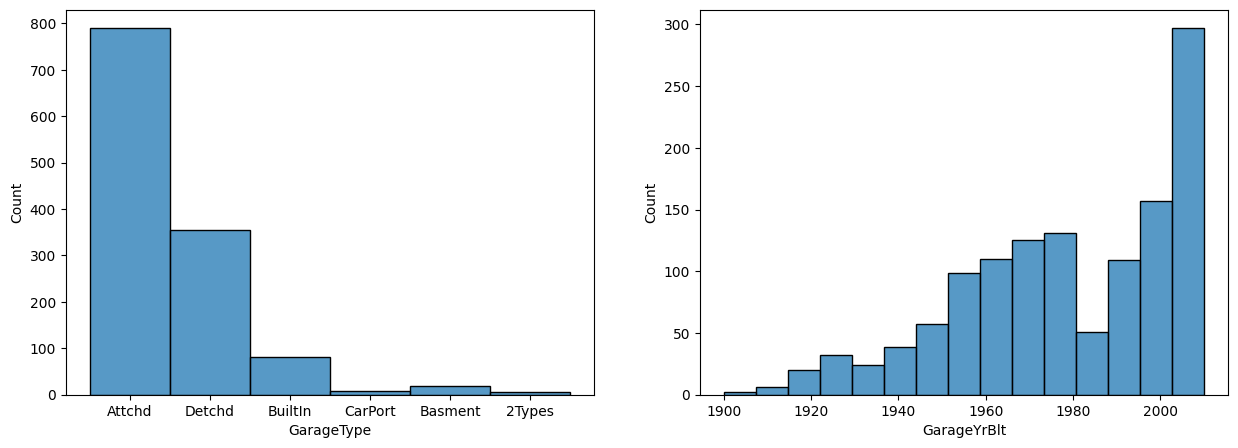

In [100]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)    # 히스토그램
sns.histplot(train['GarageType'])

plt.subplot(1, 2, 2)    # 히스토그램
sns.histplot(train['GarageYrBlt'])

plt.show()

In [101]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [102]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [103]:
train['YearBuilt'].max()      # 최신에 지어진 건물 연도 확인

2010

In [104]:
# 2011년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2011 - train['YearBuilt']
test['YearBuiltDiff'] = 2011 - test['YearBuilt']

In [105]:
train['YearRemodAdd'].max()     # 리모델링 연도 확인

2010

In [106]:
# 리모델링 여부 및 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2011 - train['YearRemodAdd']

test['RemodAddDiff'] = 2011 - test['YearRemodAdd']

In [107]:
# 차고가 지어진 연도 차이
train['NotGarageYr'] = train['GarageYrBlt']- train['YearBuilt']
test['NotGarageYr'] = test['GarageYrBlt'] - test['YearBuilt']

In [108]:
train[train['NotGarageYr'] < 0]     # 일부 0이 나타나내..?

Id  LotArea Street LotConfig  OverallQual  OverallCond  YearBuilt  \
77      78     7200   Pave    Corner            6            6       1910   
289    290    11275   Pave    Corner            7            7       1967   
543    544    10927   Pave    Inside            8            5       2005   
556    557     8402   Pave    Inside            5            5       2007   
674    675     8544   Pave    Inside            3            4       1950   
1032  1033     8910   Pave    Corner            6            6       1959   
1269  1270     6292   Pave    Inside            6            5       1930   
1301  1302    13053   Pave    Inside            6            7       1923   
1305  1306     9204   Pave    Inside            5            5       1963   
1331  1332    17217   Pave    Inside            5            5       2006   

      YearRemodAdd  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  FullBath  \
77            1998         1214      1260      1031       2291         2   
289           2007          710      1898      1080       2978         2   
543           2005         1058      1058       846       1904         2   
556           2007         1120      1120         0       1120         1   
674           1950            0      1040         0       1040         2   
1032          1959          655      1194         0       1194         1   
1269          1950          768       790         0        790         1   
1301          2000          833      1053       795       1848         1   
1305          1963         1144      1144         0       1144         1   
1331          2006         1140      1140         0       1140         1   

      HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
77           0             4             2             9           1   
289          1             5             1            11           1   
543          1             3             1             8           1   
556          0             3             1             6           0   
674          0             2             2             6           0   
1032         0             3             1             6           1   
1269         0             2             1             4           0   
1301         1             4             1             8           1   
1305         1             3             1             6           0   
1331         0             3             1             6           0   

     GarageType  GarageYrBlt  GarageCars  GarageArea  YrSold  SalePrice  \
77       Detchd       1900.0           2         506    2007     133900   
289     BuiltIn       1961.0           2         564    2010     242000   
543     BuiltIn       2003.0           2         736    2006     275000   
556      Attchd       2005.0           0           0    2007     147000   
674      Detchd       1949.0           2         400    2006      93500   
1032    BuiltIn       1954.0           2         539    2006     159500   
1269     Detchd       1925.0           1         160    2008      91000   
1301     Detchd       1922.0           2         370    2008     207000   
1305     Detchd       1962.0           1         336    2008     124000   
1331     Attchd       2005.0           0           0    2006      84500   

      YearBuiltDiff  RemodAddDiff  NotGarageYr  
77              101            13        -10.0  
289              44             4         -6.0  
543               6             6         -2.0  
556               4             4         -2.0  
674              61            61         -1.0  
1032             52            52         -5.0  
1269             81            61         -5.0  
1301             88            11         -1.0  
1305             48            48         -1.0  
1331              5             5         -1.0

In [109]:
# 음수 값은 0으로 대체
train.loc[train['NotGarageYr'] < 0, 'NotGarageYr'] = 0
test.loc[test['NotGarageYr'] < 0, 'NotGarageYr'] = 0

### 일부 feature 제거

In [110]:
no_use_features = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageArea', '1stFloor']

In [111]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

KeyError: "['1stFloor'] not found in axis"

### 중복 데이터 제거

In [ ]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [ ]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

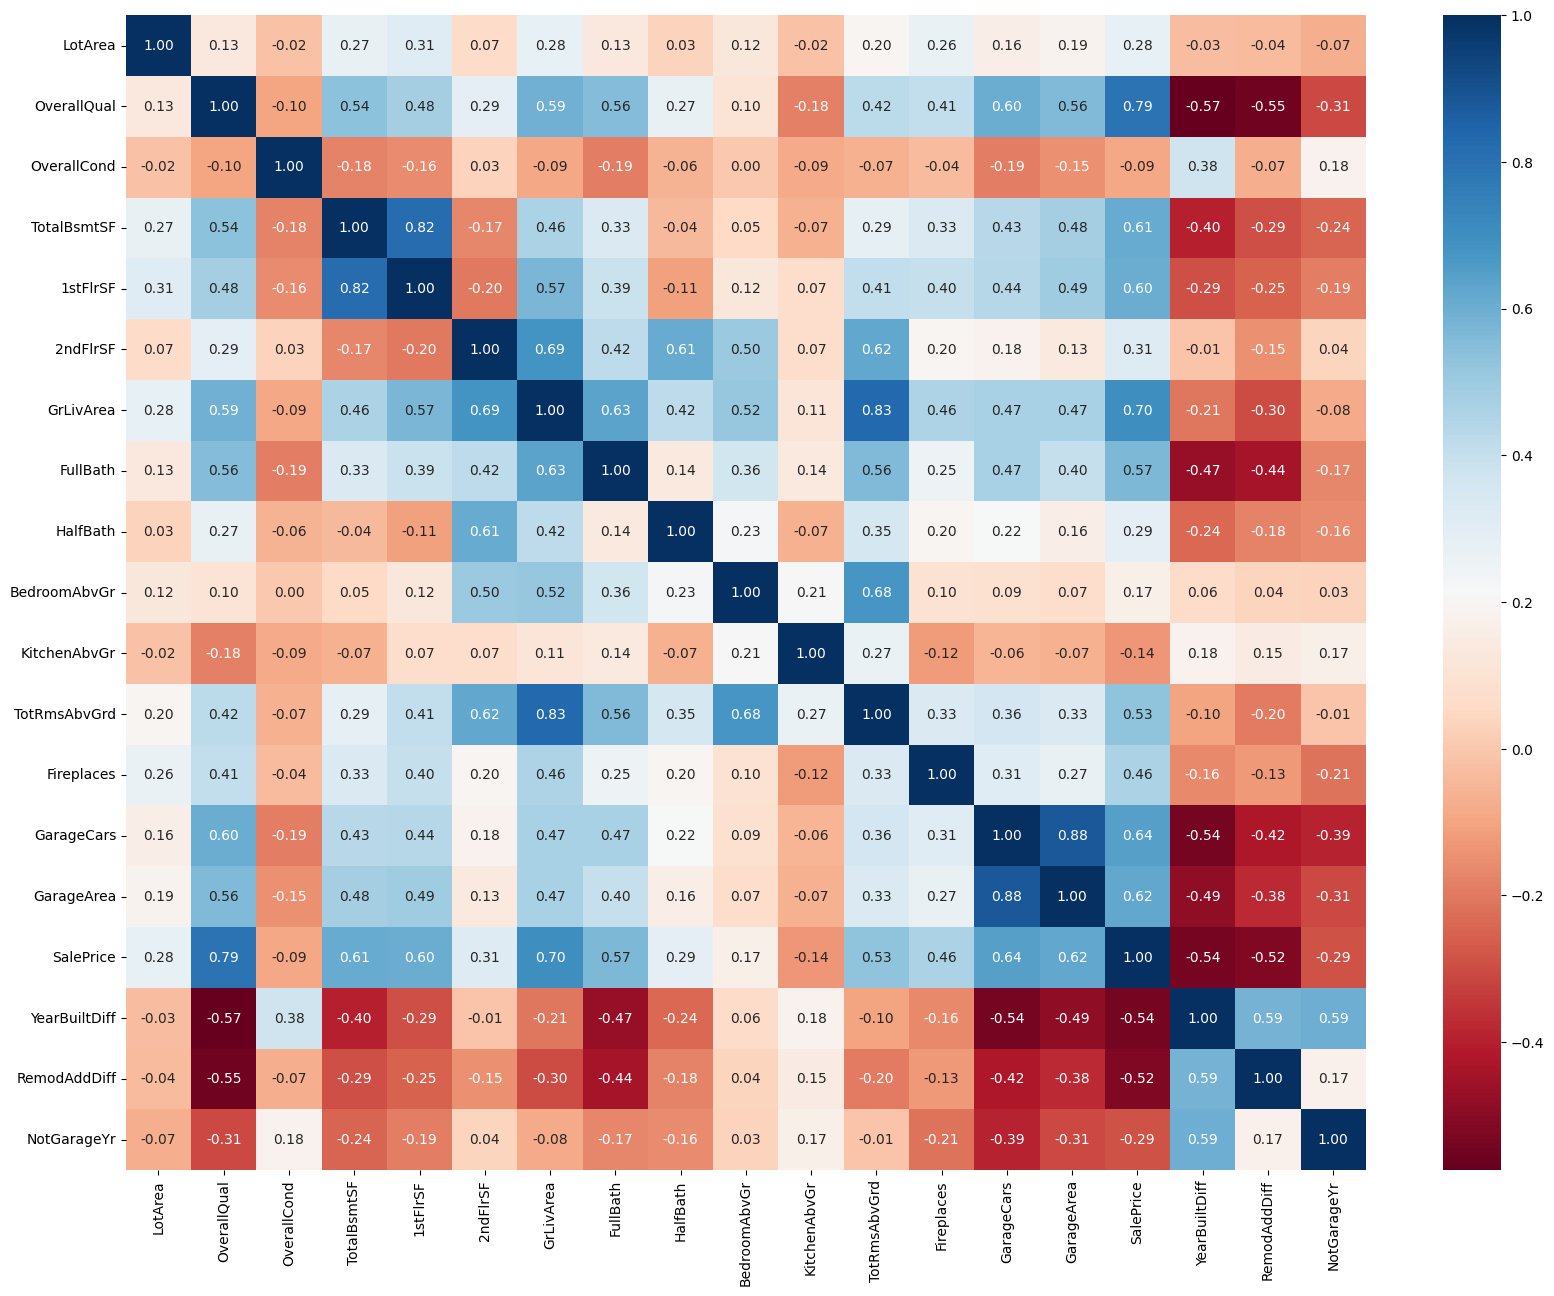

In [ ]:
# 상관계수 히트맵
numeric_data = train.select_dtypes(exclude="object")   # 수치형 데이터만 추출
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='RdBu')    # cmap: 색상  # 절반만 표시하고 싶은 경우 mask=mask 옵션 추가
plt.show()

In [ ]:
len(train.columns)

22

> LotArea

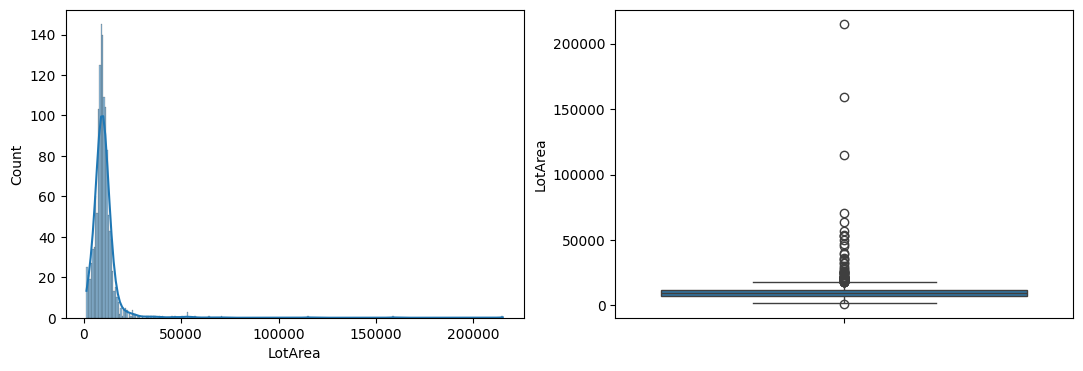

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['LotArea'], kde=True)

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(train['LotArea'])
plt.show()

In [ ]:
train = train[train['LotArea']<100000].reset_index(drop=True)    # LotArea 이상치 처리(임의)

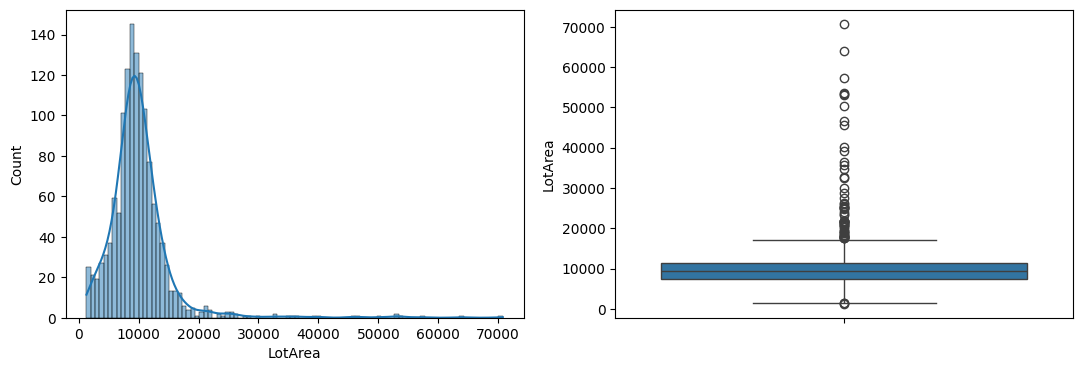

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['LotArea'], kde=True)

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(train['LotArea'])
plt.show()

> SalePrice

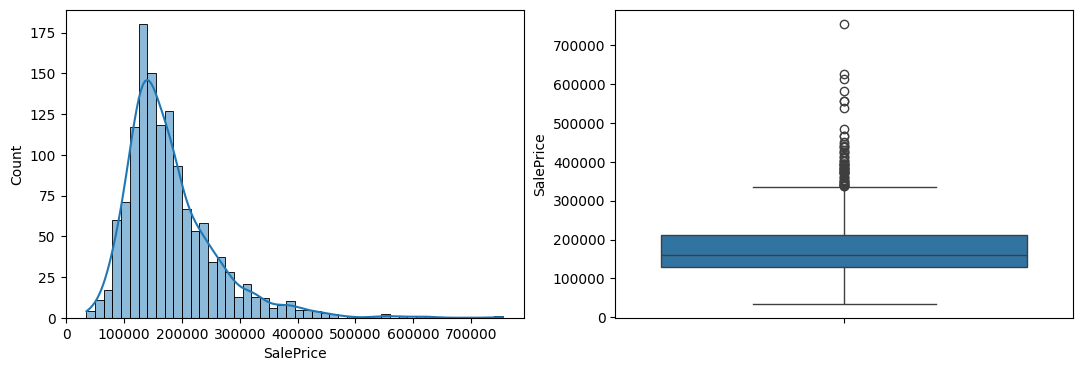

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(train['SalePrice'])
plt.show()

In [ ]:
train = train[train['SalePrice'] < 600000].reset_index(drop=True)    # SalePrice의 이상치 처리(임의)

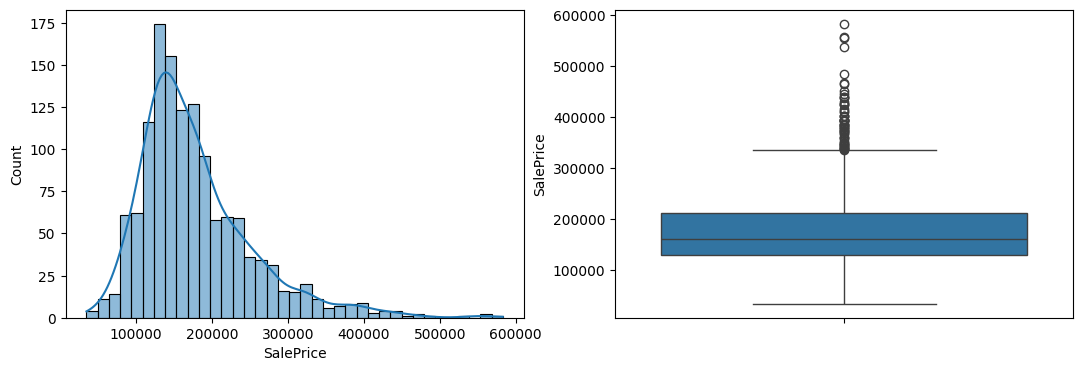

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(train['SalePrice'])
plt.show()

> GrLivArea

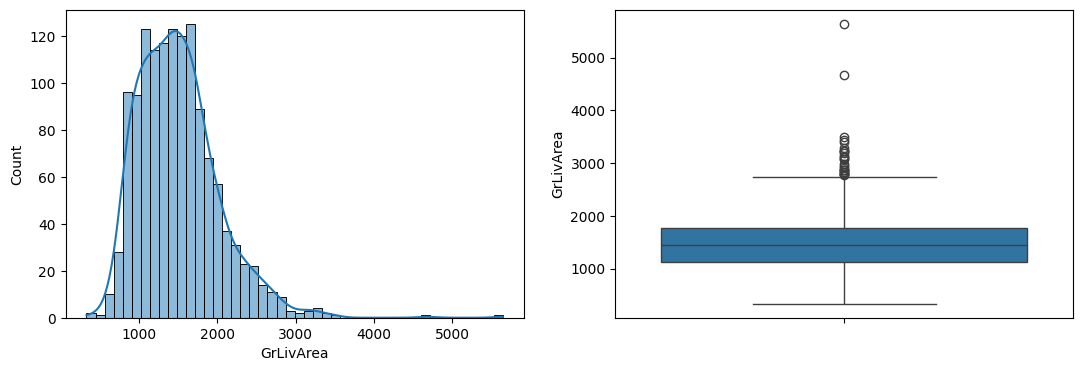

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
sns.histplot(train['GrLivArea'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(train['GrLivArea'])

plt.show()

In [ ]:
train = train[train['GrLivArea']<4000].reset_index(drop=True)

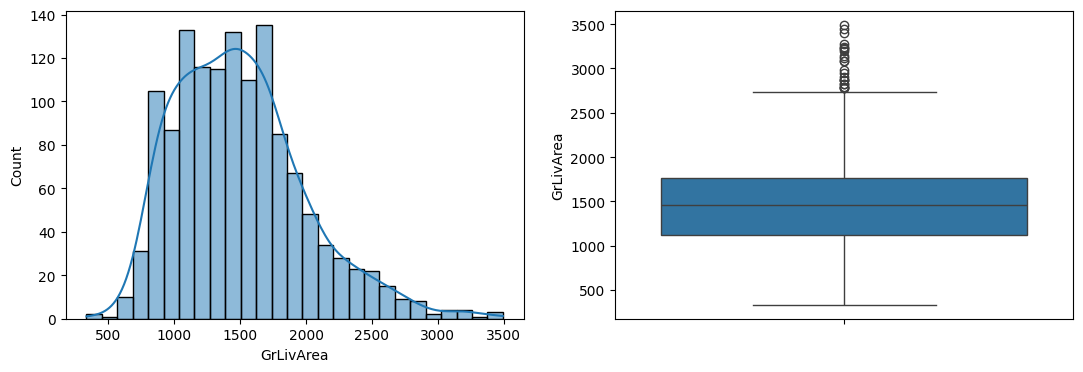

In [ ]:
# 히스토그램
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
sns.histplot(train['GrLivArea'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(train['GrLivArea'])

plt.show()

### Encoding

In [33]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [34]:
X_train

LotArea Street LotConfig  OverallQual  OverallCond  TotalBsmtSF  \
0        8450   Pave    Inside            7            5          856   
1        9600   Pave       FR2            6            8         1262   
2       11250   Pave    Inside            7            5          920   
3        9550   Pave    Corner            7            5          756   
4       14260   Pave       FR2            8            5         1145   
...       ...    ...       ...          ...          ...          ...   
1325     7917   Pave    Inside            6            5          953   
1326    13175   Pave    Inside            6            6         1542   
1327     9042   Pave    Inside            7            9         1152   
1328     9717   Pave    Inside            5            6         1078   
1329     9937   Pave    Inside            5            6         1256   

      1stFlrSF  2ndFlrSF  GrLivArea  FullBath  HalfBath  BedroomAbvGr  \
0          856       854       1710         2         1             3   
1         1262         0       1262         2         0             3   
2          920       866       1786         2         1             3   
3          961       756       1717         1         0             3   
4         1145      1053       2198         2         1             4   
...        ...       ...        ...       ...       ...           ...   
1325       953       694       1647         2         1             3   
1326      2073         0       2073         2         0             3   
1327      1188      1152       2340         2         0             4   
1328      1078         0       1078         1         0             2   
1329      1256         0       1256         1         1             3   

      KitchenAbvGr  TotRmsAbvGrd  Fireplaces GarageType  GarageCars  \
0                1             8           0     Attchd           2   
1                1             6           1     Attchd           2   
2                1             6           1     Attchd           2   
3                1             7           1     Detchd           3   
4                1             9           1     Attchd           3   
...            ...           ...         ...        ...         ...   
1325             1             7           1     Attchd           2   
1326             1             7           2     Attchd           2   
1327             1             9           2     Attchd           1   
1328             1             5           0     Attchd           1   
1329             1             6           0     Attchd           1   

      GarageArea  YearBuiltDiff  RemodAddDiff  NotGarageYr  
0            548              8             8          0.0  
1            460             35            35          0.0  
2            608             10             9          0.0  
3            642             96            41         83.0  
4            836             11            11          0.0  
...          ...            ...           ...          ...  
1325         460             12            11          0.0  
1326         500             33            23          0.0  
1327         252             70             5          0.0  
1328         240             61            15          0.0  
1329         276             46            46          0.0  

[1330 rows x 21 columns]

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

categorical = X_train.select_dtypes(include='object').columns

for feature in categorical:
    X_train[feature] = encoder.fit_transform(X_train[feature])
    test[feature] = encoder.transform(test[feature])

In [36]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(test)

# Model training

### XGBoost

In [37]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'gamma': (0, 10),
    'max_depth': (3, 15),
    'min_child_weight': (1, 10),
    }

def eval_function(max_leaves, learning_rate, n_estimators, gamma, max_depth, min_child_weight):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
    }

    xgb_model = XGBRegressor(**params, random_state=42)
    score, mean_score = rmse_cv(xgb_model)
    return -mean_score

In [38]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | max_le... | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -2.823e+0 | 3.745     | 0.4754    | 11.78     | 613.8     | 2.404     | 240.4     |
| 2         | -2.711e+0 | 0.5808    | 0.4332    | 10.21     | 725.7     | 1.185     | 972.9     |
| 3         | -2.474e+0 | 8.324     | 0.107     | 5.182     | 189.4     | 3.738     | 572.3     |
| 4         | -2.543e+0 | 4.319     | 0.1463    | 10.34     | 144.6     | 3.629     | 429.7     |
| 5         | -2.665e+0 | 4.561     | 0.3928    | 5.396     | 527.5     | 6.332     | 141.8     |
| 6         | -2.484e+0 | 8.756     | 0.01602   | 6.265     | 48.37     | 6.076     | 605.1     |
| 7         | -2.517e+0 | 8.255     | 0.181     | 4.582     | 43.39     | 5.314     | 611.5     |
| 8         | -2.627e+0 | 0.01652   | 0.1754    | 11.69     | 144.3     | 7.72      | 430.3     |
| 9         | -2.64e

In [39]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'gamma': optimizer.max['params']['gamma'],
}

best_xgb = XGBRegressor(**best_params, random_state=42)
score, mean_score = rmse_cv(best_xgb)
print(score)
print(mean_score)

[24986.9507903  23501.48759927 24925.20563051 26515.88104956
 30480.50950368 24896.00675008 21128.21645859 20997.30987522
 23618.84933233 26328.76375333]
24737.91807428758


In [40]:
best_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=8.324426408004218, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1069572162284598, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=189,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=572, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [41]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_xgb.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9988928028075575

### LightGBM

In [42]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'num_leaves': (20, 300),
    'min_child_samples': (10, 30),
    'learning_rate': (0.001, 0.5),
}

def eval_function(n_estimators, max_depth, num_leaves, min_child_samples, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'min_child_samples': int(min_child_samples),
        'learning_rate': learning_rate,
    }

    lgbm = LGBMRegressor(**params, metric='RMSE', random_state=42, verbose=0)
    score, mean_score = rmse_cv(lgbm)
    return -mean_score

In [43]:
from bayes_opt import BayesianOptimization

lgbm_optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
lgbm_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [44]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(lgbm_optimizer.max['params']['n_estimators']),
    'max_depth': round(lgbm_optimizer.max['params']['max_depth']),
    'num_leaves': round(lgbm_optimizer.max['params']['num_leaves']),
    'min_child_samples': round(lgbm_optimizer.max['params']['min_child_samples']),
    'learning_rate': lgbm_optimizer.max['params']['learning_rate'],
}

best_lgbm = LGBMRegressor(**best_params, metric='RMSE', random_state=42, verbose=0)
score, mean_score = rmse_cv(best_lgbm)
print(score, mean_score)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [45]:
best_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.07884126564776513, max_depth=4, metric='RMSE',
              min_child_samples=27, n_estimators=641, num_leaves=218,
              random_state=42, verbose=0)

In [46]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_lgbm.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9786755724917015

# 결과 제출

In [47]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [48]:
xgb_pred = best_xgb.predict(test_scaled)
lgbm_pred = best_lgbm.predict(test_scaled)

In [50]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test_scaled)
lgbm_pred = best_lgbm.predict(test_scaled)

submission['SalePrice'] = xgb_pred
submission.to_csv('test_submission1_3.csv', index=False)

submission['SalePrice'] = lgbm_pred
submission.to_csv('test_submission2_3.csv', index=False)